In [1]:
%matplotlib notebook

In [10]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
from scipy import integrate
from pyqcams import pymar, util, plotters
import pyqcams.constants as constants
import json

# Run one trajectory
First, create the QCT calculation input dictionary using the start function, with the input file as the argument.

In [2]:
calc = pymar.start('inputs.json') # Create QCT calculation inputs

## Study Potential Energy Curves

Before we run the trajectory, we should examine the potential functions describing the 3 potential molecules. Since we calculated the energy spectrum of H2, we can also plot the energy level.

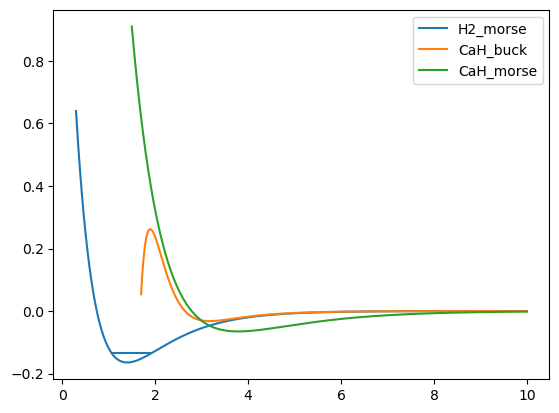

In [3]:
x1 = np.linspace(.3, 10, 1000) # Span of potential (AB)
x2 = np.linspace(1.7, 10, 1000)
x3 = np.linspace(1.5, 10, 1000)

v1 = calc['v1'] # Potential (AB)
v2 = calc['v2'] # Potential (BC)
v3 = calc['v3'] # Potential (CA)

h2 = calc['mol'] # initial molecule object is h2
vi = int(h2.get_nvib()) # initial vibrational number
elev1 = h2.evj # energy spectrum
rm, rp = h2.rm, h2.rp # turning points

plt.figure()
plt.plot(x1, v1(x1), label = 'H2_morse')
plt.plot(x2, v2(x2), label = 'CaH_buck')
plt.plot(x3, v3(x3), label = 'CaH_morse')
plt.hlines(elev1[vi], rm, rp)
plt.legend()
plt.show()

We can run a trajectory and obtain an output by running main(\**calc). Since `plot = True`, we generate trajectory and energy plots over time.

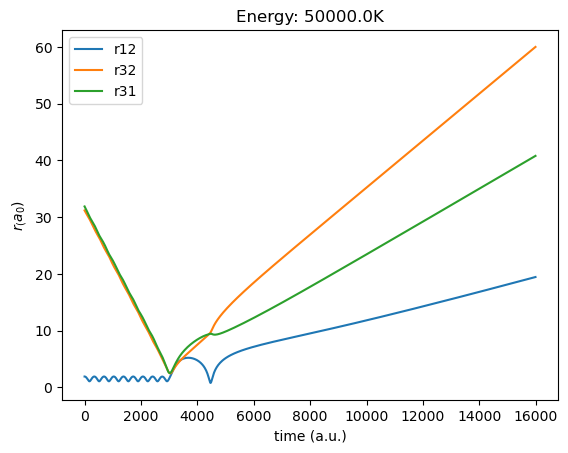

{'e': 50000.00258075955,
 'b': 0,
 'q': 0,
 'r1': 0,
 'r2': 0,
 'diss': 1,
 'comp': 0,
 'v': 0,
 'w': 0,
 'j': 0,
 'd_i': 31.523054490474422,
 'theta': 1.9453634510114057,
 'phi': 1.8158876281459737,
 'eta': 4.120256321747828,
 'n_i': 1.0,
 'j_i': 0,
 'rho1x': 0.645291446697507,
 'rho1y': -2.579930707048331,
 'rho1z': 19.26385998842023,
 'rho2x': 0.645291446697507,
 'rho2y': -2.579930707048331,
 'rho2z': 19.26385998842023,
 'p1x': 0.13910864831409966,
 'p1y': -0.5561683410469571,
 'p1z': 1.1496712593820984,
 'tf': 15990.061092372203}

In [4]:
pymar.main(plot = True,**calc)

To track specific attributes, we can define a QCT object and run a trajectory on it. Following the `main()` function, first create a QCT object, then run the trajectory. 

In [5]:
# Run a trajectory until we get dissociation.
diss = pymar.QCT(**calc)
diss.runT()
i = 0
while diss.count[3] == 0 and i < 15:
    diss.runT()
    print(diss.count)
    i += 1

[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]


In [6]:
# Run trajectory until we get a reaction
reac = pymar.QCT(**calc)
reac.runT()
while reac.count[2] == 0 and reac.count[1] == 0:
    reac.runT()
    print(reac.count)

[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[1, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 1, 0, 0, 0]


In [7]:
quench = pymar.QCT(**calc)
quench.runT()
while quench.count[0] == 0:
    quench.runT()

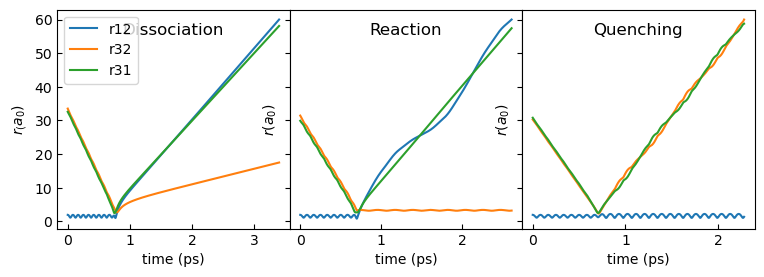

In [8]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize = (9,3))
plotters.traj_plt(diss, axs[0], title=False)
plotters.traj_plt(reac, axs[1], title=False, legend = False)
plotters.traj_plt(quench, axs[2], title=False, legend = False)
plt.subplots_adjust(wspace=0, bottom = 0.15)
axs[0].set_title('Dissociation', x= .5, y = .85)
axs[1].set_title('Reaction', x= .5, y = .85)
axs[2].set_title('Quenching', x= .5, y = .85)
axs[1].set_xlabel('time (ps)')
axs[2].set_xlabel('time (ps)')
axs[0].set_xlabel('time (ps)')
axs[0].set_ylabel('$r_(a_0)$')
axs[0].tick_params(axis = 'x', direction = 'in')
axs[1].tick_params(axis = 'x', direction = 'in')
axs[2].tick_params(axis = 'x', direction = 'in')
axs[0].tick_params(axis = 'y', direction = 'in')
# plt.show()
# plt.tight_layout(w_pad=-.3)
# fig.supxlabel('time (a.u.)', fontsize = 12)
# fig.supylabel('$r_(a_0)$', fontsize = 12, ha = 'left')

Trace the path through time.

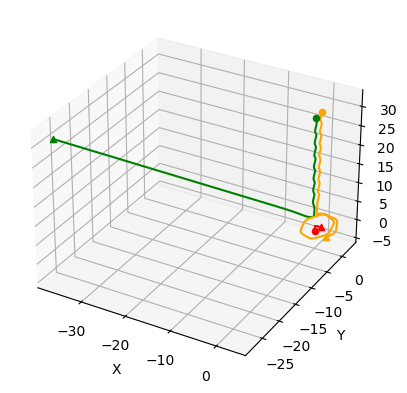

In [9]:
ax1 = plotters.traj_3d(reac)
plt.show(ax1)

c:\Users\Rian\anaconda3\lib\site-packages\matplotlib\animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

TypeError: float() argument must be a string or a number, not 'Axes3D'

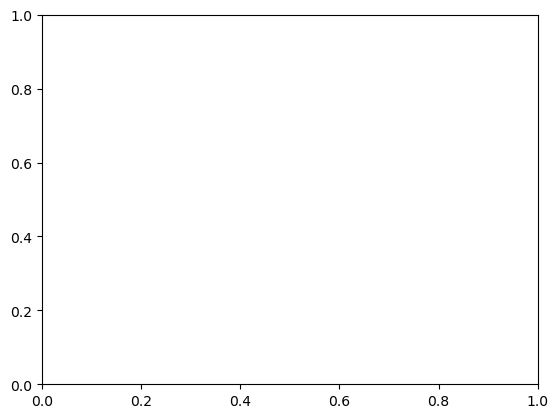

In [17]:
ax = plotters.traj_gif(diss, -160, 60)
plt.plot(ax)

# Parallel Run
For the same (Ec,b), run 'n_traj' number of trajectories, and save to 'example/results_short.csv' file. Use the `save_short` method from the `util.py` file. This can be done directy as shown in the `parallel.py` file. 

In [18]:
n_traj = 13
out_file = f'example/results_short.csv'
cpus = os.cpu_count() # Number of cpus for parallel calculation
bvals = np.arange(0,1,.25) # Range of impact parameters

calc = pymar.start('inputs.json') # Calculated parameters for main function

# loop over all impact parameters
t1 = time.time()
for b in bvals:
    calc['b'] = b # set new impact parameter
    # utils.save_long(n_traj, cpus, calc, f'{out_file}') # Uncomment for long output
    util.save_short(n_traj, cpus, calc, f'{out_file}') # Uncomment for short output
print(f'{n_traj*len(bvals)} trajectories done in {time.time()-t1} s.')

52 trajectories done in 29.338000774383545 s.


## Analyzing the data
Use pandas DataFrames to find the cross section or rates of the reaction CaH. Use a large dataset to see meaningful results.

In [19]:
# Define system parameters
with open('inputs.json','r') as f:
    data = json.load(f)
m1,m2,m3 = data['masses'].values()
mtot = m1 + m2 + m3
mu12 = m1*m2/(m1+m2) # H2
mu31 = m1*m3/(m1+m3) # CaH
mu32 = m2*m3/(m2+m3) # CaH
mu123 = m3*(m1+m2)/mtot

In [19]:
df = pd.read_csv('data/v0j0.csv') # 10000 trajectories per impact parameter (local)
df = df[df['v'] >= 0]
stats = df.iloc[:,:7].groupby(['e','b']).sum()
weights = df.drop(df.iloc[:,9:], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [20]:
# Define weights 
is_cah1 = df['r1'] == 1 
is_cah2 = df['r2'] == 1
is_cah = is_cah1 | is_cah2
cah_w = weights[is_cah].groupby(['e','b','v']).sum()
h2_w = weights[weights['h2']==1].groupby(['e','b','v']).sum()
d_w = weights[weights['d'] == 1].groupby(['e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['e','b']).sum()
net_w['w'] += net_w['d']

<IPython.core.display.Javascript object>


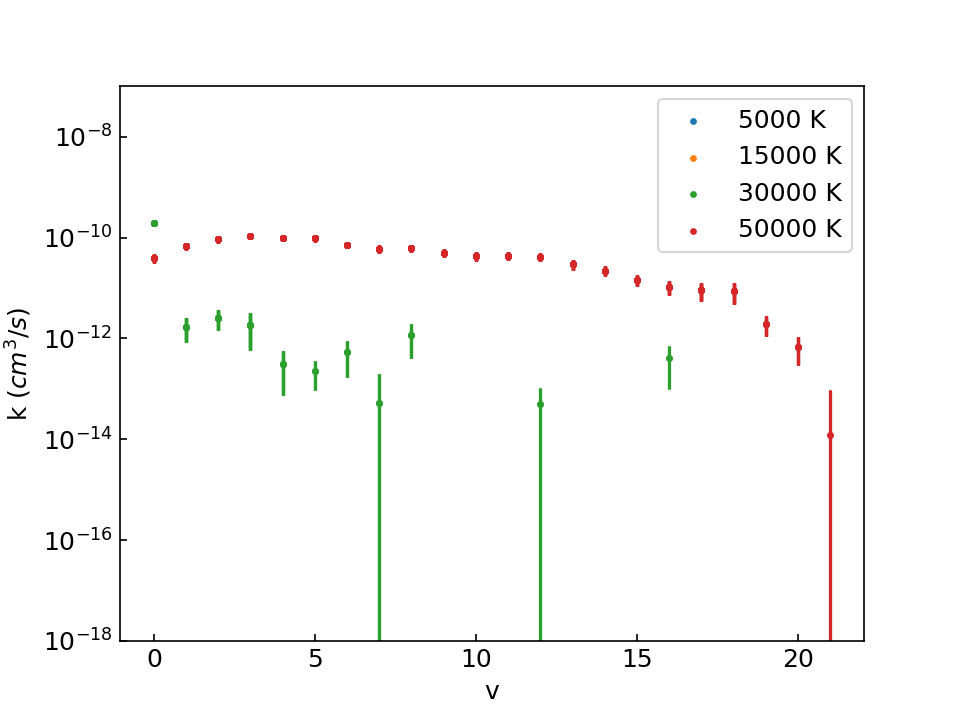

Text(0, 0.5, 'k $(cm^3/s)$')

In [27]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['e','b','v']).sum()
cah['p_r'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['perr_r'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index() # Drop dependence on b to integrate
cah.set_index(['e','v'], inplace=True)
cah['s'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah['s_err'] = cah.groupby(['e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

### Plot rate ###
cah = cah.reset_index()
evals = cah.e.unique()
evals = [5000,15000,30000, 50000]
plt.rcParams.update({'font.size':12})
plt.rc('axes', labelsize = 12)
ax = cah[cah['e']==evals[0]].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{evals[0]} K')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx,e in enumerate(evals[1:]): 
    idx += 1
    cah[cah['e']==e].plot.scatter(x='v',y='k', yerr = 'k_err', marker ='.', label = f'{e} K', c = colors[idx], ax=ax)
ax.tick_params(axis = 'x', direction = 'in')
ax.tick_params(axis = 'y', direction = 'in')
# plt.legend(bbox_to_anchor = (1,1))
plt.yscale('log')
plt.ylim(10e-19,10e-8)
plt.ylabel('k $(cm^3/s)$')
# plt.title('CaH Formation Rate Distribution ($v_i = 1$)')
# plt.savefig('results/comm_figs/cah_dist_over.svg')


## Inspect the effect of $v_i$ on CaH formation

In [20]:
df0 = pd.read_csv('../QCT/qcams/new_data/v0j0.csv')
df1 = pd.read_csv('../QCT/qcams/new_data/v1j0.csv')
df2 = pd.read_csv('../QCT/qcams/new_data/v2j0.csv')

In [26]:
df = pd.concat([df0,df1,df2])
df = df[df['v'] >= 0]
df = df.set_index('n_i')
stats = df.groupby(['e','b']).sum().loc[:,:'diss']
weights = df.drop(df.loc[:,'d_i':], axis=1)
nt = stats.sum(axis=1) # Total number of trajectories for a given (E,b)

In [29]:
# Define weights 
is_cah1 = df['cah1'] == 1 
is_cah2 = df['cah2'] == 1
is_cah = is_cah1 | is_cah2 # Combine reaction 1 and reaction 2
cah_w = weights[is_cah].groupby(['n_i','e','b','v']).sum()
h2_w = weights[weights['h2']==1].groupby(['n_i','e','b','v']).sum()
d_w = weights[weights['diss'] == 1].groupby(['n_i','e','b','v']).sum()
# Net weight should be summed over all v' values, 
# with the number of dissociation results added.
net_w = weights.groupby(['n_i','e','b']).sum()
net_w['w'] += net_w['diss']

In [31]:
# DISTRIBUTIONS
cah = df[is_cah].groupby(['n_i','e','b','v']).sum()
cah['p'] = cah_w['w']/net_w['w'] # Probability of reaction P(E,b,v)
cah['p_err'] = np.sqrt(cah_w['w'])/net_w['w']*np.sqrt((net_w['w']-cah_w['w'])/net_w['w'])
### Calculate cross section & rates ### 
cah = cah.reset_index(level = 2) # Drop dependence on b to integrate
# cah.set_index(['n_i','e','v'], inplace=True)
cah['s'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p*g.b, x=g.b))
cah['s_err'] = cah.groupby(['n_i','e','v']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_err*g.b, x=g.b))
cah['k'] = np.sqrt(2*3/2*constants.kb*cah['s'].index.get_level_values(level = 'e')/mu123)*cah['s']*constants.autocm**3/constants.ttos
cah['k_err'] = np.sqrt(2*3/2*constants.kb*cah['s_err'].index.get_level_values(level = 'e')/mu123)*cah['s_err']*constants.autocm**3/constants.ttos

In [ ]:
### Plot rate ###
cah = cah.reset_index() 
# cah = cah[cah['b'] == .75]
evals = cah.e.unique()
# evals = [40000]
evals = [5000, 20000, 30000, 40000, 50000]
plt.rcParams.update({'font.size':12})
plt.rc('axes', labelsize = 12)
wich = f'k'
ax = cah[cah['e']==evals[0]].plot.scatter(x='v',y=f'{wich}', yerr = f'{wich}_err', marker ='.', label = f'{evals[0]} K')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for idx,e in enumerate(evals[1:]): 
    idx += 1
    cah[cah['e']==e].plot.scatter(x='v',y=f'{wich}', yerr = f'{wich}_err', marker ='.', label = f'{e} K', c = colors[idx], ax=ax)
# ax.set_yscale('log')
ax.tick_params(axis = 'x', direction = 'in')
ax.tick_params(axis = 'y', direction = 'in', which = 'both')
plt.xticks(np.arange(0,int(max(cah.v.unique()))+2, 2))
# plt.legend(bbox_to_anchor = (1,1))
# plt.ylim(10e-19,10e-8)
plt.ylabel(f'${wich}_r (cm^3/s)$')
plt.title('CaH Formation Rate Distribution ($v_i = 0$)')

<IPython.core.display.Javascript object>


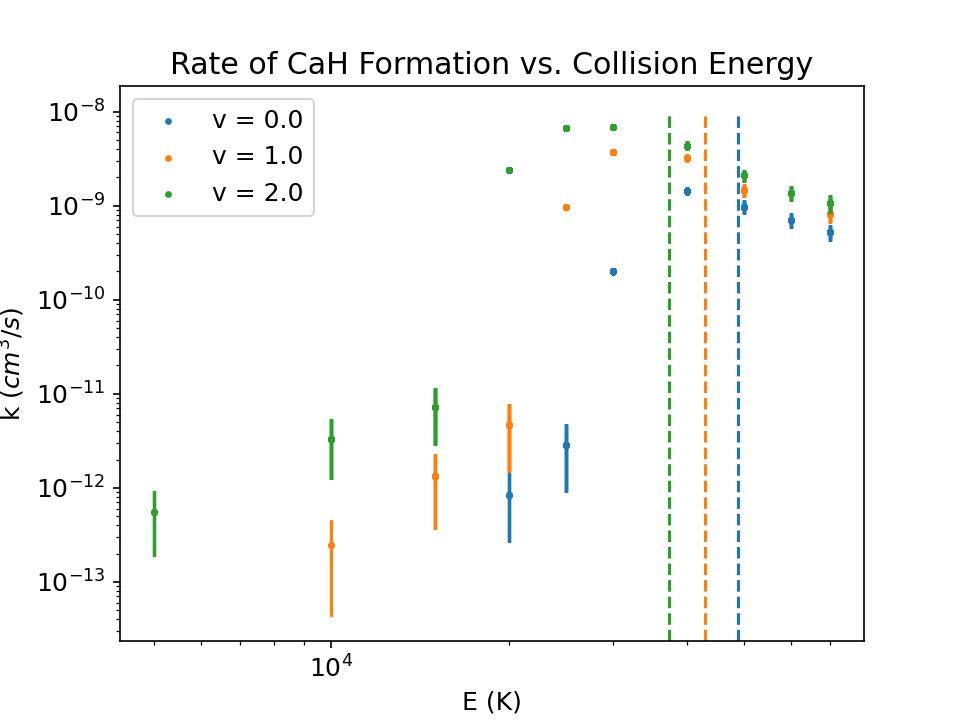

Text(0, 0.5, 'k ($cm^3/s$)')

In [33]:
# Calculate P(E,b), sigma(E), k(E) #
# Sum over v's
cah_eb = cah.reset_index().groupby(['n_i','e','b']).sum()
cah_eb = cah_eb.reset_index(level = 2) # Drop dependence on b to integrate
cah_eb['s(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.p_r*g.b, x=g.b))
cah_eb['s_err(e)'] = cah_eb.groupby(['n_i','e']).apply(lambda g: 8*np.pi**2*integrate.trapz(g.perr_r*g.b, x=g.b))
cah_eb['k(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s(e)']*constants.autocm**3/constants.ttos
cah_eb['k_err(e)'] = np.sqrt(2*3/2*constants.kb*cah_eb['s_err(e)'].index.get_level_values(level = 'e')/mu123)*cah_eb['s_err(e)']*constants.autocm**3/constants.ttos
cah_eb['s(e)'] = cah_eb['s(e)'].drop_duplicates()
cah_eb = cah_eb.reset_index()
elev = cah_eb.n_i.unique()
di = [0.15468234,0.13583315,0.11820821, 0.10180754, 0.08663113]
ax = cah_eb[cah_eb['n_i']==0].plot.scatter(x='e',y='k(e)', yerr= 'k_err(e)', marker = '.', label = f'v = {elev[0]}')
plt.vlines(di[0]/constants.cEK2H, 0, 1e-8, linestyles='dashed')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for idx,v in enumerate(elev[1:]):
    idx += 1
    cah_eb[cah_eb['n_i']==v].plot.scatter(x = 'e', y = 'k(e)', yerr = 'k_err(e)', marker = '.', label = f'v = {v}', color = colors[idx], ax=ax)
    plt.vlines(di[idx]/constants.cEK2H, 0, 1e-8, linestyles='dashed', color = colors[idx])
plt.xscale('log')
plt.yscale('log')
plt.title('Rate of CaH Formation vs. Collision Energy')
plt.xlabel('E (K)')
plt.ylabel('k ($cm^3/s$)')